In [22]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from HPA_CC.models.train import find_checkpoint_file, ClassifierLit
from HPA_CC.models.utils import classifier_inference 
from HPA_CC.data.data_viz import save_image, annotate_cell_image
from HPA_CC.data.dataset import RefImDM, RefCLSDM

from config import HOME, HPA_DS_PATH, FUCCI_DS_PATH
classes = ["M-G1", "G1", "S-G2", "G2"]
protein = "CCNB1"
data_name = "minimal"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv(HOME / 'data' / 'ifimages_v23.csv')
print(df.columns)
df.head()

Index(['filename', 'jpg_prefix', 'if_plate_id', 'position', 'sample', 'status',
       'Image status name', 'locations', 'staining characteristics',
       'unspecific', 'antibody', 'ensembl_ids', 'gene_names', 'atlas_name',
       'versions', 'earliest_version', 'first_released', 'latest_version',
       'Spatial cell cycle', 'Intensity cell cycle', 'Annotated cell cycle',
       'gain', 'x_pos', 'y_pos', 'z_pos', 'Experiment state', 'Ab state',
       'Max tpm', 'Finished in genes', 'Protocol',
       'Gene reliability (in release)', 'Gene reliability (lims)',
       'Cell count', 'well_location_predictions_all'],
      dtype='object')


,filename,jpg_prefix,if_plate_id,position,sample,status,Image status name,locations,staining characteristics,unspecific,...,z_pos,Experiment state,Ab state,Max tpm,Finished in genes,Protocol,Gene reliability (in release),Gene reliability (lims),Cell count,well_location_predictions_all
0,/archive/1/1_A1_1_,https://lims.proteinatlas.org/images/992/1_A1_1_,1,A1,1,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,7.0,NaN
1,/archive/1/1_A1_2_,https://lims.proteinatlas.org/images/992/1_A1_2_,1,A1,2,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,6.0,NaN
2,/archive/1/1_A3_1_,https://lims.proteinatlas.org/images/2899/1_A3_1_,1,A3,1,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,4.0,NaN
3,/archive/1/1_A3_2_,https://lims.proteinatlas.org/images/2899/1_A3_2_,1,A3,2,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,6.0,NaN
4,/archive/1/1_A6_1_,https://lims.proteinatlas.org/images/609/1_A6_1_,1,A6,1,35,Annotated / Proteinatlas,"Endoplasmic reticulum,Nuclear membrane",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,81.38,ENSG00000102119,PFA,Enhanced,Enhanced,5.0,NaN


In [3]:
print(df[["filename", "antibody", "gene_names"]].values[0])

['/archive/1/1_A1_1_' 'HPA000992' 'GOLGA5']


In [4]:
def prefix_to_well(filename):
    image_id = filename.split('/')[-1]
    return '_'.join(image_id.split('_')[:2])

df["well"] = df["filename"].apply(prefix_to_well)
print(df["well"].values)

['1_A1' '1_A1' '1_A3' ... '2172_F7' '2172_H8' '2172_H8']


In [5]:
CCD_prots = ["DUSP19", "DUSP18", "PAPSS1", "N6AMT1", "PHLDB1", "FLI1", "TTC21B", "PC", "UGDH", 
             "ORC6", "ZNF32", "CCNE1", "CCNB1", "AURKB", "BUB1B", "DPH2", "GMNN", "CDT1", "ANLN"]
ccd_rows = df["gene_names"].isin(CCD_prots) & df["atlas_name"].isin(["U2OS"])
ccd_df = df[ccd_rows]
print(ccd_df["filename"].values[0])
print(ccd_df[["well", "antibody", "gene_names"]].values[0])

/archive/91/91_H6_1_
['91_H6' 'HPA008419' 'BUB1B']


# Setup and Data Prep

In [6]:
# Pick a protein
DS_HOME = HPA_DS_PATH
# DS_HOME = FUCCI_DS_PATH
prot_well_names = ccd_df[ccd_df["gene_names"] == protein]["well"].unique()
prot_abs = ccd_df[ccd_df["gene_names"] == protein]["antibody"].unique()
print(prot_well_names)
print(prot_abs)
# prot_well_names = ["chamber--U01--V00"]

['663_E2' '845_A6' '1671_B6']
['CAB000115' 'HPA030741' 'HPA061448']


<Figure size 640x480 with 0 Axes>

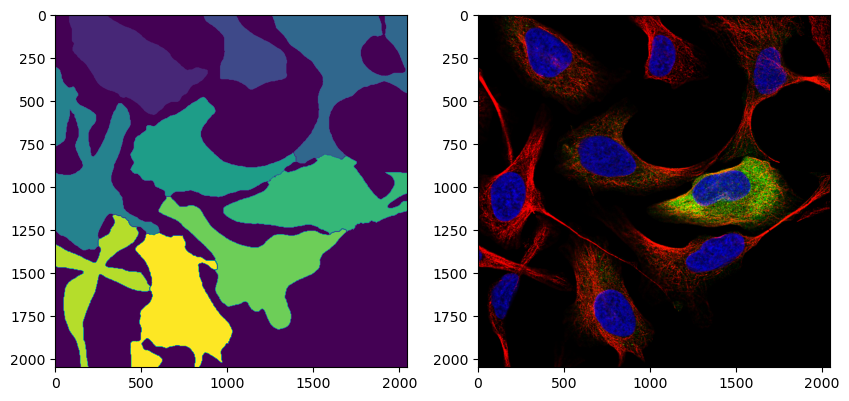

<Figure size 640x480 with 0 Axes>

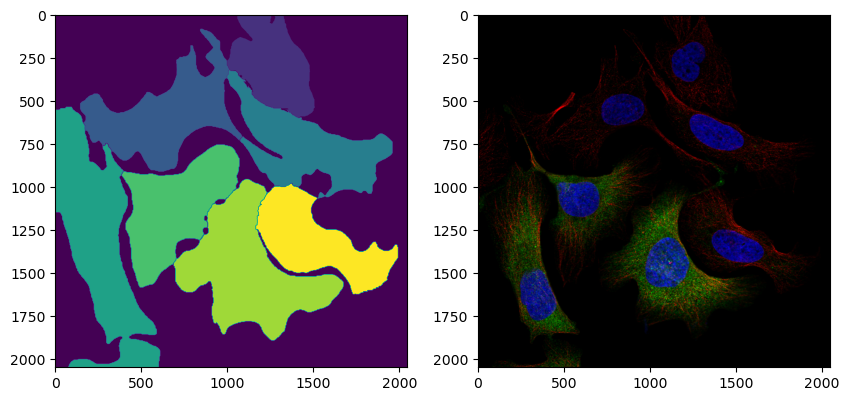

<Figure size 640x480 with 0 Axes>

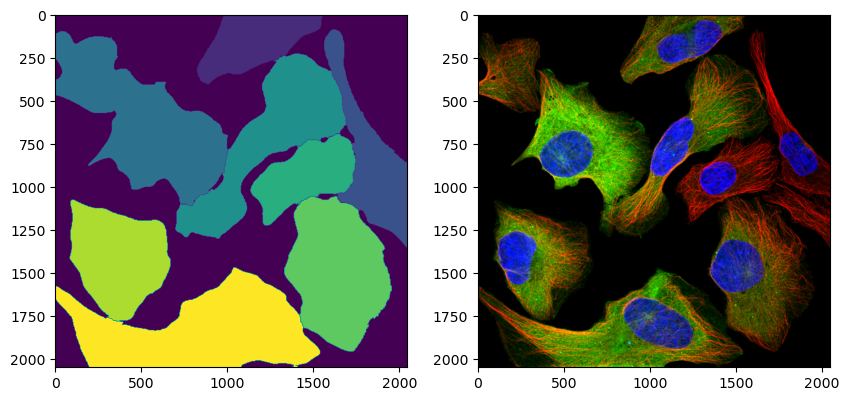

<Figure size 640x480 with 0 Axes>

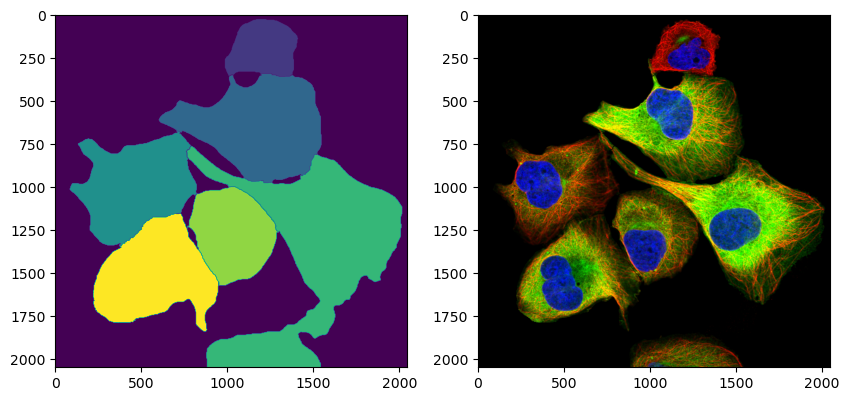

<Figure size 640x480 with 0 Axes>

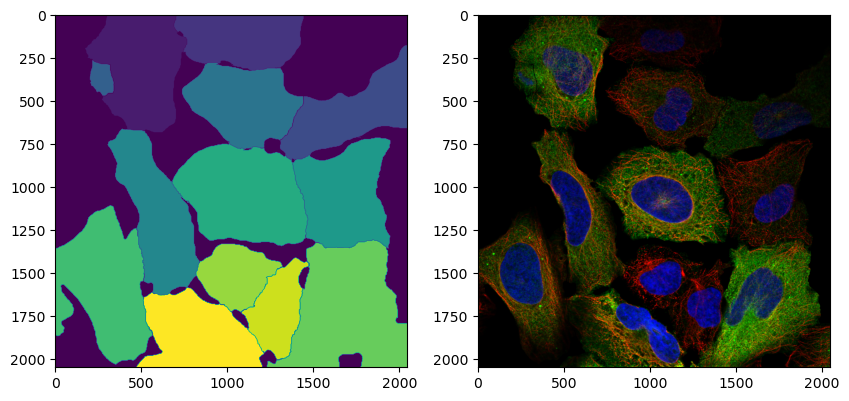

<Figure size 640x480 with 0 Axes>

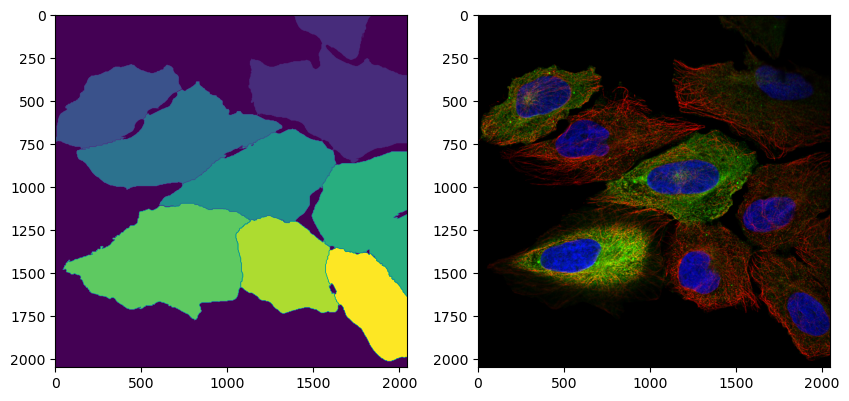

In [7]:
# prep data needed for model inference and visualization

image_paths = []
cell_mask_paths = []
for well in prot_well_names:
    # should really get these from the dataset config
    image_paths.append(DS_HOME / well / f"imagesmin_max.npy")
    cell_mask_paths.append(DS_HOME / well / f"cell_masks_no_border_rm_1000_sharp_none.npy")
    # cell_mask_paths.append(DS_HOME / well / f"cell_masks_no_border_rm_1000_sharp_1250.npy")

images = np.concatenate([np.load(p) for p in image_paths])

masks = [np.load(p) for p in cell_mask_paths]
n_per_well = [len(m) for m in masks]
masks = np.concatenate(masks)

ref_images = images[:, :2, ...]
color_images = [save_image(torch.Tensor(I[[0, 1, 3]]), HOME / "temp.png", cmaps=["pure_blue", "pure_red", "pure_green"]) for I in images]
# color_images = [save_image(torch.Tensor(I[[3]]), HOME / "temp.png", cmaps=["pure_green"]) for I in images]
# color_images = [save_image(torch.Tensor(I), HOME / "temp.png", cmaps=["pure_blue", "pure_yellow", "pure_green", "pure_red"]) for I in images]
# target_images = [save_image(torch.Tensor(I[[2, 3]]), HOME / "temp.png", cmaps=["pure_green", "pure_red"]) for I in images]

for i in range(len(color_images)):
    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(masks[i])
    ax[1].imshow(color_images[i])
    plt.show()

sc_images = torch.concat([torch.load(DS_HOME / well / "images_minimal.pt") for well in prot_well_names])
assert len(sc_images) == sum([len(np.unique(m)) - 1 for m in masks])

In [8]:
from torch.utils.data import DataLoader
from HPA_CC.data.dataset import SimpleDataset


log_dirs_home = Path("/data/ishang/pseudotime_pred/")
device = "cuda:0"
model_name = "Conv Classifier"
model_hash = "ikgoxh4k" # og w aug
model_hash = "f557ujip" # gamma 3
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
phase_model = ClassifierLit.load_from_checkpoint(checkpoint_file)
phase_model.to(device)
phase_model.eval()
dataset = SimpleDataset(tensor=sc_images[:, :2, ...])
dataloader = DataLoader(dataset, batch_size=32, num_workers=1, shuffle=False)
# phase_preds = []
# with torch.no_grad():
#     for batch in iter(dataloader):
#         batch = batch.to(device)
#         batch_preds = phase_model(batch).cpu()
#         phase_preds.append(batch_preds)
# phase_preds = torch.cat(phase_preds)
# phase_preds = phase_preds.argmax(dim=1).numpy()
# print(phase_preds.shape)
phase_preds = classifier_inference(phase_model, dataloader, device)

/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181081/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


# Annotated Images

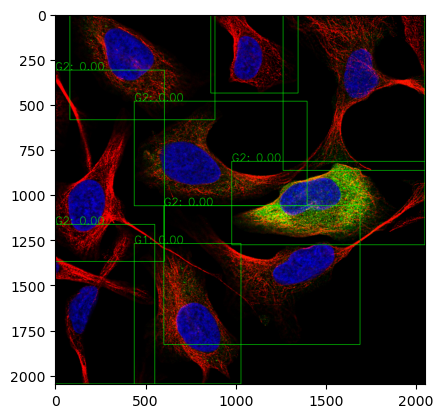

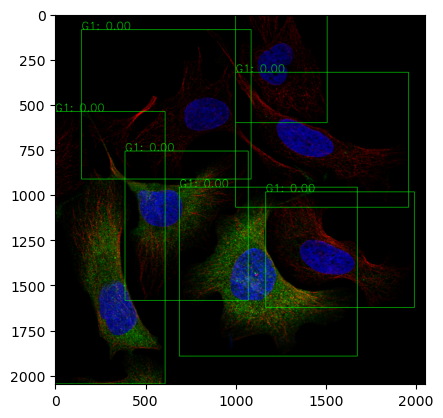

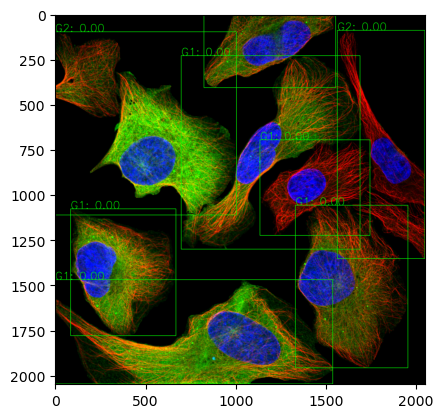

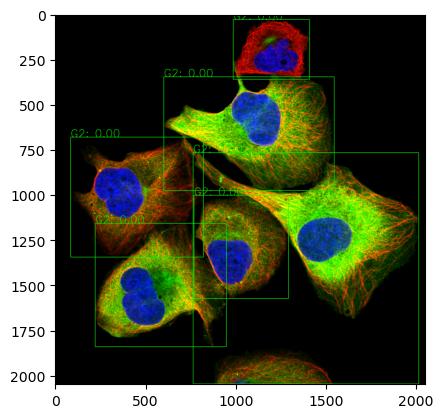

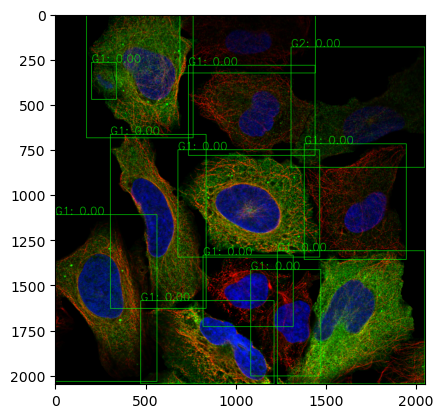

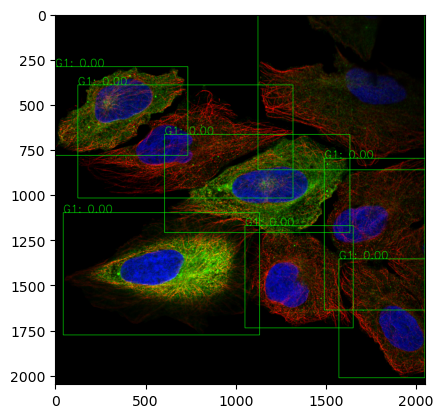

In [9]:
classes = ["M-G1", "G1", "S-G2", "G2"]
cell_idx = 0
for image, mask in zip(color_images, masks):
# for image, mask in zip(target_images, masks):
    n_cells = len(np.unique(mask)) - 1
    phases = phase_preds[cell_idx:cell_idx + n_cells]
    phases = [classes[p] for p in phases]
    image = np.array(image)
    annotated_image = annotate_cell_image(image, mask, np.zeros((n_cells,)), phases)
    cell_idx += n_cells
    plt.clf()
    plt.imshow(annotated_image)
    plt.show()

# HPA Prediction Histograms

In [42]:
HPA_dm = RefImDM(HPA_DS_PATH, data_name, 32, 1, inference=True)
FUCCI_dm = RefImDM(FUCCI_DS_PATH, data_name, 32, 1, split=(0.64, 0.16, 0.2), label="phase", scope=True)

Loading dataset images:   0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset images: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


Loaded 1870 images from 68 files.
X shape: torch.Size([1870, 2, 512, 512])


Loading dataset images: 100%|██████████| 1/1 [01:12<00:00, 72.31s/it]


Loaded 31737 images from 136 files.
X shape: torch.Size([31737, 2, 512, 512])


In [43]:
h_phase_preds = classifier_inference(phase_model, HPA_dm.inference_dataloader(), device)
f_phase_preds = classifier_inference(phase_model, FUCCI_dm.test_dataloader(), device)

In [53]:
def get_img_labels(data):
    print(data.shape)
    well_label = 0
    curr_well = data[0][1536:]
    img_labels = np.zeros((len(data),))
    for i in range(len(img_labels)):
        if not np.equal(data[i][1536:], curr_well).all():
            well_label += 1
            curr_well = data[i][1536:]
        img_labels[i] = well_label
    print(len(np.unique(img_labels)))
    return img_labels
hpa_img_dm = RefCLSDM(HPA_DS_PATH, data_name, 32, 1, inference=True, concat_well_stats=True)
fucci_img_dm = RefCLSDM(FUCCI_DS_PATH, data_name, 32, 1, label="phase", split=(0.64, 0.16, 0.2), concat_well_stats=True, scope=True)
h_img_labels = get_img_labels(hpa_img_dm.dataset.X)
f_img_labels = get_img_labels(fucci_img_dm.dataset.X[fucci_img_dm.split_indices["test"]])
# f_img_labels = get_img_labels(fucci_img_dm.dataset.X)

Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/all_HPA-CC-dataset/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([1870, 1536])
X shape: torch.Size([1870, 2048])
Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/FUCCI-dataset-well/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([31737, 1536])
X shape: torch.Size([31737, 2048])
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_phase_scope.pt
Y shape: torch.Size([31737, 4])
torch.Size([1870, 2048])
134
torch.Size([31737, 2048])
2222


In [45]:
num_classes = 4
def img_spreads(sc_phase_preds, img_labels):
    img_phase_spreads = []
    for i in range(len(np.unique(img_labels))):
        img_phase_preds = sc_phase_preds[img_labels == i]
        N = len(img_phase_preds)
        class_cts = np.unique(img_phase_preds, return_counts=True)[1]
        spread = ((class_cts ** 2).sum() - N) / (N * (N - 1))
        img_phase_spreads.append(spread)
    return img_phase_spreads

h_img_spreads = img_spreads(h_phase_preds, h_img_labels)
f_img_spreads = img_spreads(f_phase_preds, f_img_labels)    

plt.clf()
plt.hist(h_img_spreads, bins=15, alpha=0.5, density=True, label="HPA")
plt.hist(f_img_spreads, bins=15, alpha=0.5, density=True, label="FUCCI")
plt.legend()
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6347 but corresponding boolean dimension is 31737

[0.56569104 0.27307252 0.08581989 0.02283875 0.02103309] 0.8387635569987726


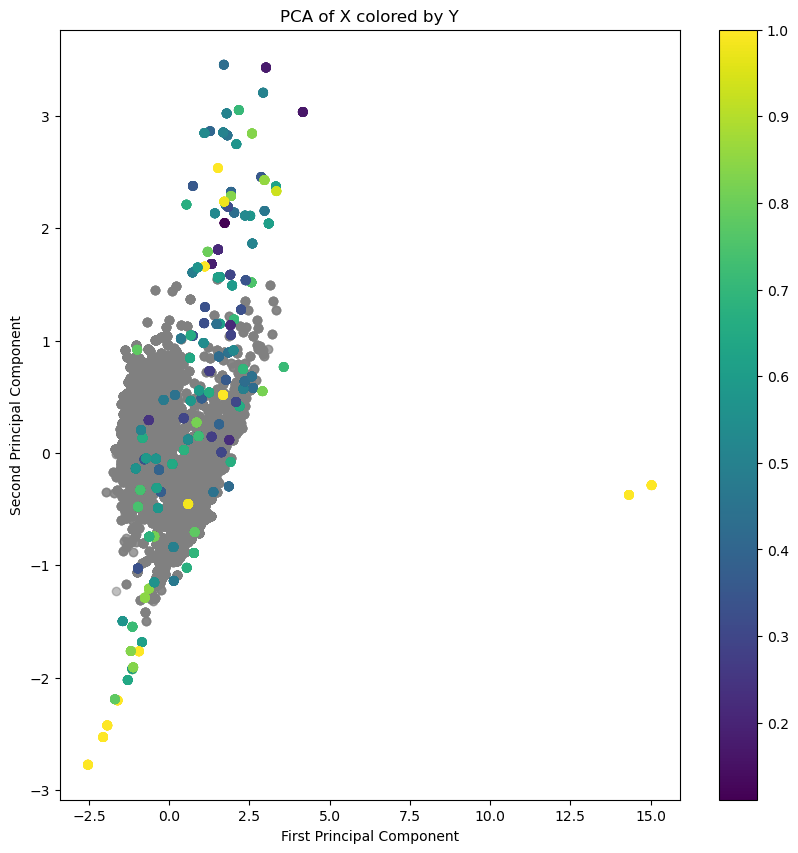

In [ ]:
X = torch.concat([HPA_dm.dataset.X, FUCCI_dm.dataset.X], dim=0)
Y = np.zeros((len(X),))
for i in range(len(np.unique(img_labels))):
    well_idx = np.where(img_labels == i)[0]
    Y[well_idx] = well_pseudo_pred_spreads[i]


# Perform PCA on X
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X[:, 1536:])
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_[:2]))
# Create a scatter plot of the first two principal components
# fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
# axes[1].scatter(X_pca[len(h_pseudo_preds):, 0], X_pca[len(h_pseudo_preds):, 1], c=Y[len(h_pseudo_preds):], cmap='viridis', alpha=0.5)
# sc = axes[0].scatter(X_pca[:len(h_pseudo_preds), 0], X_pca[:len(h_pseudo_preds), 1], c=Y[:len(h_pseudo_preds)], cmap='viridis', alpha=0.5)
fig = plt.figure(figsize=(10, 10))
plt.scatter(X_pca[len(h_pseudo_preds):, 1], X_pca[len(h_pseudo_preds):, 2], color='gray', alpha=0.5)
sc = plt.scatter(X_pca[:len(h_pseudo_preds), 1], X_pca[:len(h_pseudo_preds), 2], c=Y[:len(h_pseudo_preds)], cmap='viridis')
plt.colorbar(sc)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of X colored by Y')
plt.show()


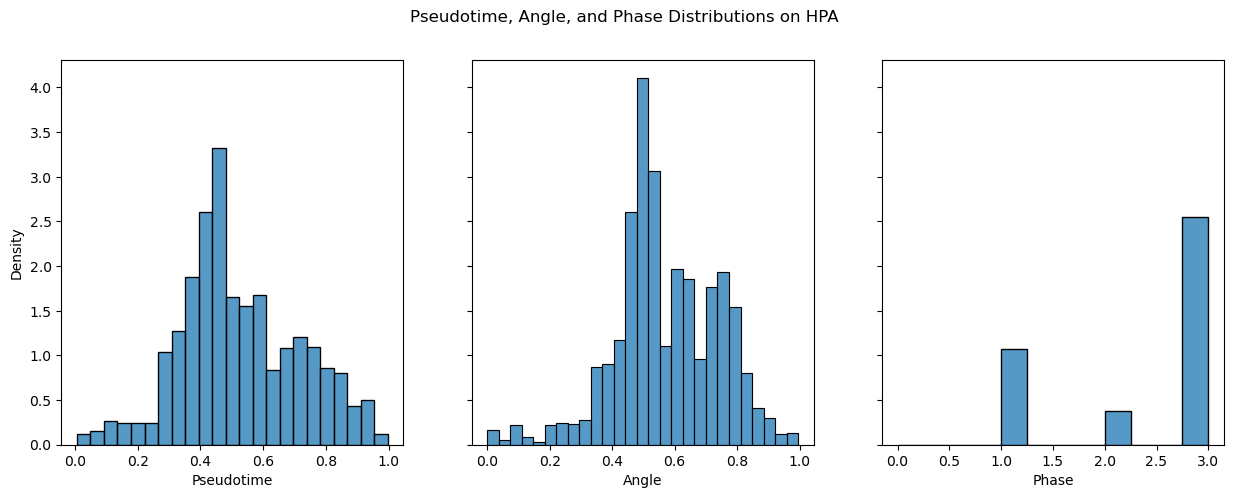

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.histplot(pseudo_preds, ax=ax[0], stat="density")
sns.histplot(angle_preds, ax=ax[1], stat="density")
sns.histplot(phase_preds, ax=ax[2], stat="density")
ax[0].set_xlabel("Pseudotime")
ax[1].set_xlabel("Angle")
ax[2].set_xlabel("Phase")
plt.ylabel("Density")
fig.suptitle("Pseudotime, Angle, and Phase Distributions on HPA")
plt.show()